In [1]:
from matplotlib import pyplot as plt
import scanpy as sc
from scipy.sparse import csr_matrix, identity
from scipy.linalg import expm, logm
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, rankdata
from sklearn.decomposition import NMF
import soptsc as so
import networkx as nx
import igraph as ig
import leidenalg as la
import collections
import numpy as np
import random as rm
import itertools
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

# Haensel et al. (2020) #

In [2]:
%%time
# Read in the Haensel et al. (2020)
haenseldata = sc.read_loom('/Users/axelalmet/Documents/scRNASeqData/Haensel2020/haenselunwounded.loom')

CPU times: user 4min 37s, sys: 1min 8s, total: 5min 46s
Wall time: 5min 47s


In [3]:
# Separate the data by the tissue samples
haenseldata_sample1 = haenseldata[haenseldata.obs['run'] == 'bs_1']
haenseldata_sample2 = haenseldata[haenseldata.obs['run'] == 'bs_2']

In [7]:
haenseldata_sample1.shape

(5260, 16827)

In [8]:
haenseldata_sample2.shape

(5355, 16827)

In [10]:
haenseldata_sample1.obs['ClusterName'][5259]

'Fibroblast II'

In [11]:
pathway_names = ['Tgfb', 'ncWnt', 'Egf', 'Pdgf', 'Bmp', 'Notch', 'Cdh'] # Name of the signalling_pathways
ligand_receptor_pairs = [[('Tgfb1', ['Tgfbr1', 'Tgfbr2']), ('Tgfb2', ['Tgfbr1', 'Tgfbr2'])], \
                        [('Wnt5a', 'Fzd2'), ('Wnt5a', 'Fzd4'), ('Wnt5a', 'Fzd10'), ('Wnt5a', 'Mcam')], \
                        [('Areg', 'Egfr'), ('Hbegf', 'Egfr')], \
                        [('Pdgfa', 'Pdgfra'), ('Pdgfb', 'Pdgfrb')],\
                        [('Bmp1', ['Bmpr1a','Bmpr2']), ('Bmp1', ['Bmpr1b','Bmpr2']), \
                         ('Bmp2', ['Bmpr1a','Bmpr2']), ('Bmp2', ['Bmpr1b','Bmpr2']),\
                         ('Bmp4', ['Bmpr1a','Bmpr2']), ('Bmp4', ['Bmpr1b','Bmpr2']),\
                         ('Bmp7', ['Bmpr1a','Bmpr2']), ('Bmp7', ['Bmpr1b','Bmpr2'])],\
                        [('Jag1', 'Notch1'), ('Jag1', 'Notch3'), ('Dll1', 'Notch1'), ('Dll1', 'Notch3')],\
                        [('Cdh1', 'Cdh1'), ('Cdh4', 'Cdh4')]] # Name of the ligand-receptor pairs

haensel1_so = so.SoptSC(haenseldata_sample1, pathway_names, ligand_receptor_pairs)
haensel2_so = so.SoptSC(haenseldata_sample2, pathway_names, ligand_receptor_pairs)

In [14]:
haensel1_so.cell_ids['ClusterName']

bs_1_AAACCTGAGCCGTCGT-1                Epidermal spinous
bs_1_AAACCTGCAAGGGTCA-1    Proliferative epidermal basal
bs_1_AAACCTGCACCCATGG-1              Epidermal basal III
bs_1_AAACCTGCAGATCCAT-1                Epidermal spinous
bs_1_AAACCTGCAGATCTGT-1                           HF III
                                       ...              
bs_1_TTTGTCAGTGGTCTCG-1                           HF III
bs_1_TTTGTCAGTTCCACGG-1                           HF III
bs_1_TTTGTCATCATATCGG-1                Epidermal spinous
bs_1_TTTGTCATCTCAACTT-1                    Fibroblast II
bs_1_TTTGTCATCTTACCTA-1                    Fibroblast II
Name: ClusterName, Length: 5260, dtype: object

In [42]:
cell_clusters = haensel1_so.cell_ids['ClusterName']
cluster_labels = list(cell_clusters.unique()) # Get the unique list of clusters
num_clusters = len(cluster_labels)
cluster_pairs = {(i, j):1 for i, j in itertools.product(range(num_clusters), range(num_clusters))}

In [58]:
haensel1_so.data[haensel1_so.cell_ids['ClusterName'].isin(['Epidermal spinous'])]

View of AnnData object with n_obs × n_vars = 964 × 16827
    obs: 'ClusterID', 'ClusterName', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mito', 'res_0_6', 'run'
    var: 'Selected'
    obsm: 'cca.aligned_cell_embeddings', 'cca_cell_embeddings', 'tsne_cell_embeddings'
    varm: 'cca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [59]:
spinous_cells = haensel1_so.cell_ids[haensel1_so.cell_ids['ClusterName'] == 'Epidermal spinous']

In [80]:
cells_A = np.where(haensel1_so.cell_ids['ClusterName'] == 'Fibroblast III')[0]
cells_B = np.where(haensel1_so.cell_ids['ClusterName'] == 'Epidermal spinous')[0]

In [81]:
cell_pairs = {(i, j):1 for i, j in itertools.product(cells_A, cells_B)}

In [7]:
%%time
# Calculate the individual and aggregated probabilities for both samples
haensel1_so.calculate_individual_probabilities(pathway_names, mean_type = 'Geometric') # Calculate the individual probability matrices
haensel2_so.calculate_individual_probabilities(pathway_names, mean_type = 'Geometric') # Calculate the individual probability matrices

CPU times: user 8min 22s, sys: 2min 20s, total: 10min 43s
Wall time: 5min 27s


In [10]:
import pickle
file_pickle = open('sopsc_haensel2020.obj', 'wb')
pickle.dump([haensel1_so, haensel2_so], file_pickle)

In [11]:
sopsc_list = pickle.load(open('sopsc_haensel2020.obj', 'rb'))

In [7]:
%%time
# Construct the networks
haensel1_so.construct_individual_networks(pathway_names) # Construct the individual networks for each individual probability matrix
haensel2_so.construct_individual_networks(pathway_names) # Construct the individual networks for each individual probability matri

CPU times: user 12.5 s, sys: 613 ms, total: 13.1 s
Wall time: 13.4 s


In [8]:
# Define the number of cells, networks, and layers for different signalling pathways

# Number of cells
num_cells1 = len(haensel1_so.cell_ids)
num_cells2 = len(haensel2_so.cell_ids)

# Network lists
G_tgfb_list1 = haensel1_so.individual_networks['Tgfb']
G_ncwnt_list1 = haensel1_so.individual_networks['ncWnt']
G_egf_list1 = haensel1_so.individual_networks['Egf']
G_pdgf_list1 = haensel1_so.individual_networks['Pdgf']
G_bmp_list1 = haensel1_so.individual_networks['Bmp']
G_notch_list1 = haensel1_so.individual_networks['Notch']
G_cdh_list1 = haensel1_so.individual_networks['Cdh']

G_tgfb_list2 = haensel2_so.individual_networks['Tgfb']
G_ncwnt_list2 = haensel2_so.individual_networks['ncWnt']
G_egf_list2 = haensel2_so.individual_networks['Egf']
G_pdgf_list2 = haensel2_so.individual_networks['Pdgf']
G_bmp_list2 = haensel2_so.individual_networks['Bmp']
G_notch_list2 = haensel2_so.individual_networks['Notch']
G_cdh_list2 = haensel2_so.individual_networks['Cdh']

# Number of layers
num_tgfb_layers = len(G_tgfb_list1)
num_ncwnt_layers = len(G_ncwnt_list1)
num_egf_layers = len(G_egf_list1)
num_pdgf_layers = len(G_pdgf_list1)
num_bmp_layers = len(G_bmp_list1)
num_notch_layers = len(G_notch_list1)
num_cdh_layers = len(G_cdh_list1)

# Also deefine the edge pairs for faster iteration
edge_pairs1 = dict((i, j) for i, j in itertools.product(range(num_cells1), range(num_cells1)) if i < j)
edge_pairs2 = dict((i, j) for i, j in itertools.product(range(num_cells2), range(num_cells2)) if i < j)

## Betweenness centrality of aggregated networks

In [15]:
# Look at the aggregated networks and see how betweenness centrality varies
supra_betweenness_centralities1 = {}
supra_betweenness_centralities2 = {}

In [25]:
%%time
num_cells = num_cells1
# Calculate the betweenness centralities for the first sample
for pathway in haensel1_so.individual_probabilities:
    
    # Get the list of probabilities
    P_list = haensel1_so.individual_probabilities[pathway]
    num_layers = len(P_list)
    
    # Construct the supra adjacency and then the relevant graph
    supra_adjacency = csr_matrix((num_cells * num_layers, num_cells * num_layers))
    for i in range(num_layers):
        supra_adjacency[i * num_cells : (i + 1)*num_cells, i * num_cells : (i + 1)*num_cells] = P_list[i]
    
    # Construct the supra-adjacency matrix
    G_supra = nx.from_scipy_sparse_matrix(supra_adjacency, create_using=nx.DiGraph, edge_attribute = 'probability')
    supra_betweenness =  nx.betweenness_centrality(G_supra, weight='probability')

    betweenness_centralities = np.zeros(num_cells)

    for i in range(num_layers):
        betweenness_centralities += np.array([supra_betweenness[j] for j in range(i*num_cells, (i + 1)*num_cells)])
    
    supra_betweenness_centralities1[pathway] = betweenness_centralities

KeyboardInterrupt: 

In [16]:
%%time
num_cells = num_cells2
# Calculate the betweenness centralities for the second sample
for pathway in haensel2_so.individual_probabilities:
    
    # Get the list of probabilities
    P_list = haensel2_so.individual_probabilities[pathway]
    num_layers = len(P_list)
    
    # Construct the supra adjacency and then the relevant graph
    supra_adjacency = csr_matrix((num_cells * num_layers, num_cells * num_layers))
    for i in range(num_layers):
        supra_adjacency[i * num_cells : (i + 1)*num_cells, i * num_cells : (i + 1)*num_cells] = P_list[i]
    
    # Construct the supra-adjacency matrix
    G_supra = nx.from_scipy_sparse_matrix(supra_adjacency, create_using=nx.DiGraph, edge_attribute = 'probability')
    supra_betweenness =  nx.betweenness_centrality(G_supra, weight='probability')

    betweenness_centralities = np.zeros(num_cells)

    for i in range(num_layers):
        betweenness_centralities += np.array([supra_betweenness[j] for j in range(i*num_cells, (i + 1)*num_cells)])
    
    supra_betweenness_centralities2[pathway] = betweenness_centralities

KeyboardInterrupt: 

In [24]:
supra_betweenness_centralities1

{'Tgfb': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.01221311e-07]),
 'ncWnt': array([0., 0., 0., ..., 0., 0., 0.]),
 'Egf': array([0., 0., 0., ..., 0., 0., 0.]),
 'Pdgf': array([0., 0., 0., ..., 0., 0., 0.])}

## Examining multidigraphs for bridges

In [17]:
# Let us try and create multidigraphs 
multi_digraphs1 = {}
multi_digraphs2 = {}

In [19]:
num_cells = num_cells1
# Calculate the digraphs for the first sample
for pathway in haensel1_so.individual_probabilities:
    
    # Get the list of probabilities
    P_list = haensel1_so.individual_probabilities[pathway]
    num_layers = len(P_list)
    
    aggregated_adjacency = csr_matrix((num_cells, num_cells))
    
    # For each time we record an edge, add 1 to the adjacency matrix
    for i in range(num_layers):
        A = P_list[i]
        A[A > 0.0] = 1.0
        aggregated_adjacency += A
        
    # Create the multi-digraph using networkx functionality
    multi_digraphs1[pathway] = nx.convert_matrix.from_scipy_sparse_matrix(aggregated_adjacency, 
                                                                            create_using=nx.MultiDiGraph,
                                                                              parallel_edges=True)


num_cells = num_cells2
# Create the digraphs
for pathway in haensel2_so.individual_probabilities:
    
    # Get the list of probabilities
    P_list = haensel2_so.individual_probabilities[pathway]
    num_layers = len(P_list)
    
    aggregated_adjacency = csr_matrix((num_cells, num_cells))
    
    # For each time we record an edge, add 1 to the adjacency matrix
    for i in range(num_layers):
        A = P_list[i]
        A[A > 0.0] = 1.0
        aggregated_adjacency += A
        
    multi_digraphs2[pathway] = nx.convert_matrix.from_scipy_sparse_matrix(aggregated_adjacency, 
                                                                            create_using=nx.MultiDiGraph,
                                                                              parallel_edges=True)

## Infomap community detection

In [38]:
# We need to convert the multilayer networks into the Pajek format.
num_cells = num_cells1
for pathway in haensel1_so.individual_probabilities:
    with open('multilayer_' + pathway + '_1.net', 'a') as f:
        # We should write down the vertices so that infomap knows there's a bunch of isolated nodes
        f.write('*Vertices ' + str(num_cells) + '\n')
        for i in range(num_cells):
            
            f.write(str(i) + ''' "''' + str(i) + '''"\n''')
            
        # Write the edges now
        P_list = haensel1_so.individual_probabilities[pathway]
        num_layers = len(P_list)
        
        # Write the multilayer heading
        f.write('*Multilayer\n')
        
        # Write the labels of columns so we know what's going on
        f.write('# layer_id node_id layer_id node_id weight\n') # Column IDs
        f.write('# intra\n') # Intra-layer links (we won't have any interlayer links)
        
        # Go through each layer
        for i in range(num_layers):
            P = P_list[i] # Probability matrix
            nz_rows, nz_cols = P.nonzero()  # We only need to write the places where there's an edge
            
            for j in range(len(nz_rows)):
                f.write(str(i) + ' ' + str(nz_rows[j]) + ' ' + str(i) + ' ' + str(nz_cols[j]) + ' ' + str(P[nz_rows[j], nz_cols[j]]) +'\n')


In [39]:
# We need to convert the multilayer networks into the Pajek format.
num_cells = num_cells2
for pathway in haensel2_so.individual_probabilities:
    with open('multilayer_' + pathway + '_2.net', 'a') as f:        
        # We should write down the vertices so that infomap knows there's a bunch of isolated nodes
        f.write('*Vertices ' + str(num_cells) + '\n')
        for i in range(num_cells):
            
            f.write(str(i) + ''' "''' + str(i) + '''"\n''')
            
        # Write the edges now
        P_list = haensel2_so.individual_probabilities[pathway]
        num_layers = len(P_list)
        
        # Write the multilayer heading
        f.write('*Multilayer\n')
        
        # Write the labels of columns so we know what's going on
        f.write('# layer_id node_id layer_id node_id weight\n') # Column IDs
        f.write('# intra\n') # Intra-layer links (we won't have any interlayer links)
        # Go through each layer
        for i in range(num_layers):
            P = P_list[i] # Probability matrix
            nz_rows, nz_cols = P.nonzero()  # We only need to write the places where there's an edge
            
            for j in range(len(nz_rows)):
                f.write(str(i) + ' ' + str(nz_rows[j]) + ' ' + str(i) + ' ' + str(nz_cols[j]) + ' ' + str(P[nz_rows[j], nz_cols[j]]) +'\n')


In [26]:
import infomap

In [45]:
pathways = [pathway for pathway in haensel1_so.individual_probabilities]
print(pathways)

['Tgfb', 'ncWnt', 'Egf', 'Pdgf', 'Bmp', 'Notch', 'Cdh']


In [53]:
# Run infomap
!infomap -i multilayer -o tree,ftree,clu multilayer_Cdh_1.net ./output/
!infomap -i multilayer -o tree,ftree,clu multilayer_Cdh_2.net ./output/

  Infomap v1.3.0 starts at 2021-02-04 12:41:47
  -> Input network: multilayer_Cdh_1.net
  -> Output path:   ./output/
  -> Configuration: input-format = multilayer
                    output = tree,ftree,clu
Parsing multilayer network from file 'multilayer_Cdh_1.net'... 
  Parsing multilayer links...
  -> 0 links in 0 layers
    -> 0 intra-layer links
    -> 0 inter-layer links
  Parsing vertices...
  -> 5260 physical nodes added
  Parsing multilayer links...
  -> 303713 links in 2 layers
    -> 303713 intra-layer links
    -> 0 inter-layer links
Done!
-------------------------------------
  -> 2599 state nodes
  -> 5260 physical nodes
  -> 303422 links with total weight 2599
  -> Found higher order network input, using the Map Equation for higher order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 2599 nodes and 303422 links...
Calculating one-level codele

## Graph-tool community detection

In [8]:
import graph_tool as gt
import matplotlib as matplotlib

In [2]:
import pickle

sopsc_list = pickle.load(open('sopsc_haensel2020.obj', 'rb'))
haensel1_so = sopsc_list[0]
haensel2_so = sopsc_list[1]

In [9]:
g = gt.collection.ns["new_guinea_tribes"]

# The edge types are stored in the edge property map "weights".

# Note the different meanings of the two 'layers' parameters below: The
# first enables the use of LayeredBlockState, and the second selects
# the 'edge layers' version (instead of 'edge covariates').

# state = gt.inference.minimize_nested_blockmodel_dl(g, layers=True,
#                                          state_args=dict(ec=g.ep.weight, layers=True))

# state.draw(edge_color=g.ep.weight, edge_gradient=[],
#            ecmap=(matplotlib.cm.coolwarm_r, .6), edge_pen_width=5,
#            output="tribes-sbm-edge-layers.png")

In [12]:
dict(ec=g.ep.weight, layers=True)

{'ec': <EdgePropertyMap object with value type 'int16_t', for Graph 0x1cd9884f0, at 0x1d28adcd0>,
 'layers': True}

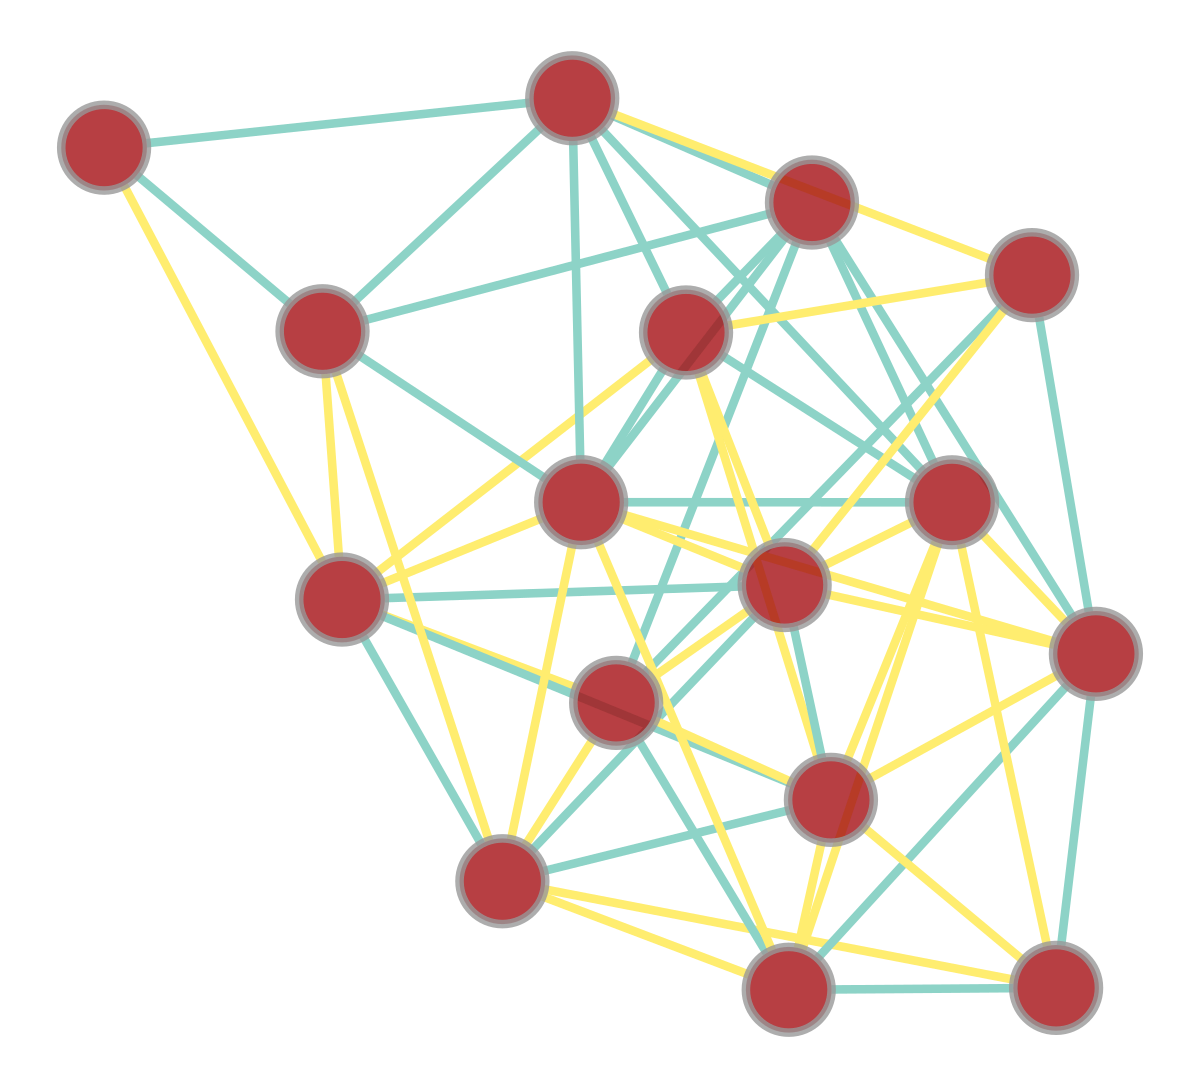

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1cd9884f0, at 0x1d4135ee0>

In [10]:
graph_draw(g, edge_color = g.ep.weight)

In [46]:
g.edge_properties['weight']

<EdgePropertyMap object with value type 'int16_t', for Graph 0x1d4aa4d30, at 0x1d4aa4fa0>

In [11]:
for e in g.edges():
    print(g.edge_properties['weight'][e])

1
-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
-1
1
1
-1
-1
1
1
1
1
1
1
-1
1
-1
1
-1
-1
1
-1
1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
1
